# 주택 가격 예측: 회귀 문제
- 개별적인 레이블 대신에 연속적인 값 예측하기

## 보스턴 주택 데이터셋 로드하기

In [2]:
from keras.datasets import boston_housing

(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

In [3]:
train_data.shape

(404, 13)

In [4]:
test_data.shape

(102, 13)

In [5]:
train_targets

array([15.2, 42.3, 50. , 21.1, 17.7, 18.5, 11.3, 15.6, 15.6, 14.4, 12.1,
       17.9, 23.1, 19.9, 15.7,  8.8, 50. , 22.5, 24.1, 27.5, 10.9, 30.8,
       32.9, 24. , 18.5, 13.3, 22.9, 34.7, 16.6, 17.5, 22.3, 16.1, 14.9,
       23.1, 34.9, 25. , 13.9, 13.1, 20.4, 20. , 15.2, 24.7, 22.2, 16.7,
       12.7, 15.6, 18.4, 21. , 30.1, 15.1, 18.7,  9.6, 31.5, 24.8, 19.1,
       22. , 14.5, 11. , 32. , 29.4, 20.3, 24.4, 14.6, 19.5, 14.1, 14.3,
       15.6, 10.5,  6.3, 19.3, 19.3, 13.4, 36.4, 17.8, 13.5, 16.5,  8.3,
       14.3, 16. , 13.4, 28.6, 43.5, 20.2, 22. , 23. , 20.7, 12.5, 48.5,
       14.6, 13.4, 23.7, 50. , 21.7, 39.8, 38.7, 22.2, 34.9, 22.5, 31.1,
       28.7, 46. , 41.7, 21. , 26.6, 15. , 24.4, 13.3, 21.2, 11.7, 21.7,
       19.4, 50. , 22.8, 19.7, 24.7, 36.2, 14.2, 18.9, 18.3, 20.6, 24.6,
       18.2,  8.7, 44. , 10.4, 13.2, 21.2, 37. , 30.7, 22.9, 20. , 19.3,
       31.7, 32. , 23.1, 18.8, 10.9, 50. , 19.6,  5. , 14.4, 19.8, 13.8,
       19.6, 23.9, 24.5, 25. , 19.9, 17.2, 24.6, 13

## 데이터 정규화하기
- 머신 러닝 작업 과정에서 절대 테스트 데이터에서 계산한 어떤 값도 사용해서는 안됨

In [6]:
mean = train_data.mean(axis=0)
train_data -= mean

std = train_data.std(axis=0)
train_data /= std

test_data -= mean
test_data /= std

## 모델 정의하기
- 샘플수가 적기때문에 64개의 유닛을 가진 2개의 은닉 층으로 작은 네트워크를 구성
- 훈련 데이터의 개수가 적을수록 과대적합이 더 쉽게 일어나므로 작은 모델을 사용하는 것이 과대적합을 피할 수 있음

In [8]:
from keras import models
from keras import layers

def build_model():   # 동일한 모델을 여러번 생성할 것이므로 함수를 만들어서 사용
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))   # 스칼라 회귀를 위한 구상: 활성화 함수 없음
    model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
    return model

## K-겹 검증을 사용한 훈련 검증

In [9]:
# epochs = 100

import numpy as np

k=4
num_val_samples = len(train_data)//k
num_epochs = 100
all_scores = []

for i in range(k):
    print('처리중인 폴드 #', i)
    
    # 검증 데이터 준비: k번째 분할
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
    
    # 훈련 데이터 준비: 다른 분할 전체
    partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)
    
    model = build_model()   # 케라스 모델 구성(컴파일 포함)
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size=1, verbose=0)
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose=0)
    all_scores.append(val_mae)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


In [10]:
all_scores

[2.0416483879089355, 2.315563917160034, 2.6905949115753174, 2.2995212078094482]

In [11]:
np.mean(all_scores)

2.336832106113434

## 각 폴드에서 검증 점수를 로그에 저장하기

In [16]:
# epochs = 500

num_epochs = 500
all_mae_histories = []

for i in range(k):
    print('처리중인 폴드 #', i)
    
    val_data = train_data[i*num_val_samples: (i+1)*num_val_samples]
    val_targets = train_targets[i*num_val_samples: (i+1)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(i+1)*num_val_samples:]], axis=0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], train_targets[(i+1)*num_val_samples:]], axis=0)
    
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets,
                        validation_data = (val_data, val_targets),
                        epochs=num_epochs, batch_size=1, verbose=0)
    mae_history = history.history['val_mae']
    all_mae_histories.append(mae_history)

처리중인 폴드 # 0
처리중인 폴드 # 1
처리중인 폴드 # 2
처리중인 폴드 # 3


## K-겹 검증 점수 평균을 기록하기

In [17]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

## 검증 점수 그래프

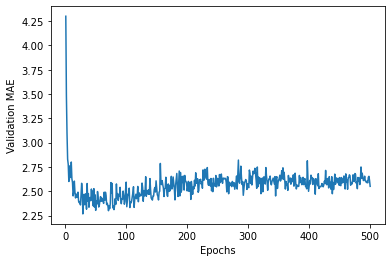

In [18]:
import matplotlib.pyplot as plt

plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## 처음 10개의 데이터 포인트를 제외한 검증 점수 그리기
- 곡선의 다른 부분과 스케일이 많이 다른 첫 10개의 데이터 포인트를 제외
- 부드러운 곡선을 얻기 위해 각 포인트를 이전 포인트의 지수 이동 평균으로 대체
- 검증 MAE가 80째 에포크 이후 줄어드는 것이 멈춤 -> 과대적합 시작

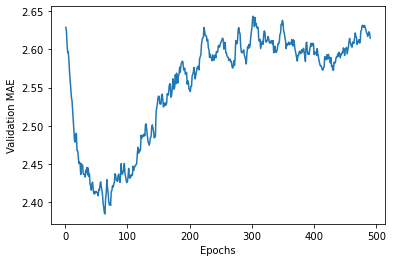

In [19]:
def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous*factor + point*(1-factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

smooth_mae_history = smooth_curve(average_mae_history[10:])

plt.plot(range(1, len(smooth_mae_history)+1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

## 최종 모델 훈련하기

In [20]:
model = build_model()
model.fit(train_data, train_targets, epochs=80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

4/4 [==============================] - 0s 2ms/step - loss: 19.1622 - mae: 2.6330


In [21]:
test_mae_score

2.632972478866577